In [2]:
import os
import pickle
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Load the results ------------------------------------------------
# ------------------------------------------------------------------
results_dir  = "particle count"
pickle_file  = os.path.join(results_dir, "particles count_results.pkl")

with open(pickle_file, "rb") as f:
    delta_results = pickle.load(f)

# ------------------------------------------------------------------
# 2. Arrange the data ------------------------------------------------
# ------------------------------------------------------------------
# Sort the keys so the x‑axis is monotone
m_values   = sorted(delta_results.keys())

mean_IS    = [delta_results[m]["mean_obj"]  for m in m_values]
std_IS     = [delta_results[m]["std_obj"]   for m in m_values]

mean_time  = [delta_results[m]["mean_time"] for m in m_values]
std_time   = [delta_results[m]["std_time"]  for m in m_values]

import numpy as np


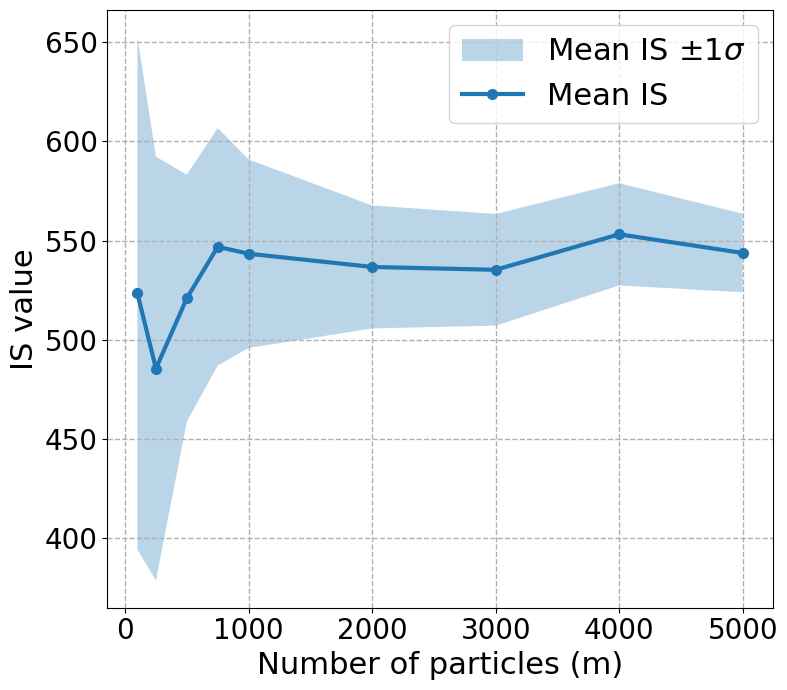

In [16]:
# Ensure lists are converted to NumPy arrays
m_values = np.array(m_values)
mean_IS = np.array(mean_IS)
std_IS = np.array(std_IS)

n=22
# Compute bounds
lower = mean_IS - std_IS
upper = mean_IS + std_IS

plt.figure(figsize=(8, 7))
plt.fill_between(m_values, lower, upper, alpha=0.3, label=r"Mean IS ±1$\sigma$")
plt.plot(m_values, mean_IS, "o-", label="Mean IS", linewidth=3,markersize=7)
plt.xlabel("Number of particles (m)", fontsize = n)
plt.ylabel("IS value", fontsize = n)
plt.legend(loc = "best", fontsize = n)
plt.tick_params(axis="both", which="major", labelsize=n-2)
plt.grid(True, which="both", linestyle="--", linewidth=1)
plt.tight_layout()
plt.savefig('partciles_delta0.025.pdf', bbox_inches = 'tight')

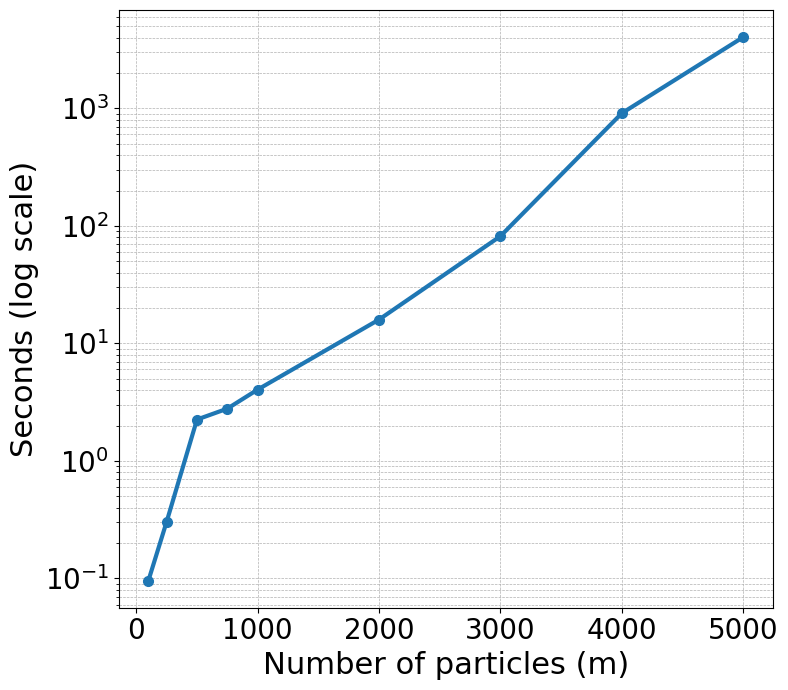

In [18]:
# ------------------------------------------------------------------
# 3b. Plot mean solve‑time with std solve‑time as error bars -------
#     (logarithmic y‑axis)                                          -
# ------------------------------------------------------------------
plt.figure(figsize=(8, 7))
plt.plot(m_values, mean_time, "o-", linewidth=3,markersize=7)
#plt.title(r"Solver Runtime per run vs. Particle Count ($\delta = 0.025$)", fontsize = 20)
plt.xlabel("Number of particles (m)", fontsize = n)
plt.ylabel("Seconds (log scale)", fontsize = n)
plt.yscale("log")       # <-- log‑scale here
plt.tick_params(axis="both", which="major", labelsize=n-2)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig('partciles_runtim0.025.pdf', bbox_inches = 'tight')



In [34]:
import math
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ["GRB_LICENSE_FILE"] = "/nfs/home/colinn/gurobi.lic"
import gurobipy as gp
from gurobipy import GRB

print("Gurobi version:", gp.gurobi.version())

# -------------------------
# Parameter Setup
# -------------------------
N = 10             # Number of time intervals
X = 1e3            # Total shares to sell
T = 10             # Trading horizon
tau = T / N        # Length of each interval

s = 0.0625         # Spread cost per share
eta = 2.5e-03      # Temporary impact coefficient
gamma = 2.5e-04    # Permanent impact parameter
sigma = 0.95       # Volatility

M = 1e6            # Big-M constant
C_max = 2563       # Threshold for implementation shortfall

delta = 1
num_runs = 30      # Monte Carlo replications per δ


# To store results
delta_results = {}
delta_list = [100, 250, 500, 750, 1000, 1500, 2000, 2500, 3000, 4000, 5000]

# -------------------------
# Run optimization for each delta
# -------------------------
for m in delta_list:
    print(f"Processing particles: {m}")

    # per‐run storage
    inventory_plots = []
    trade_plots     = []
    obj_vals        = []
    solve_times     = []
    tail_probs      = []

    for run in range(num_runs):
        # simulate random shocks
        xi = np.random.normal(0, 1, (m, N))
        gamma_samples = np.random.normal(gamma, 0, m)

        # build model
        model = gp.Model("FixedGammaOpt")
        model.setParam('OutputFlag', 0)

        n_vars = model.addVars(N, lb=0, name="n")
        b_vars = model.addVars(m, vtype=GRB.BINARY, name="b")
        model.addConstr(gp.quicksum(n_vars[k] for k in range(N)) == X, "TotalShares")

        IS_expr = []
        for p in range(m):
            perm_term = (
                0.5 * gamma_samples[p] * X**2
                - 0.5 * gamma_samples[p] * gp.quicksum(n_vars[k] * n_vars[k] for k in range(N))
            )
            spread_term = s * X
            temp_term   = eta * gp.quicksum((n_vars[k] * n_vars[k]) / tau for k in range(N))

            stoch = gp.LinExpr()
            for k in range(N):
                inv_expr_k = X - gp.quicksum(n_vars[i] for i in range(k+1))
                stoch += inv_expr_k * xi[p, k]
            stoch = sigma * math.sqrt(tau) * stoch

            IS_p = perm_term + spread_term + temp_term + stoch
            IS_expr.append(IS_p)
            model.addQConstr(IS_p <= C_max + M * b_vars[p], name=f"IS_Constraint_{p}")

        model.addConstr(gp.quicksum(b_vars[p] for p in range(m)) <= delta * m, "ChanceConstraint")
        model.setObjective((1.0 / m) * gp.quicksum(IS_expr[p] for p in range(m)), GRB.MINIMIZE)

        model.optimize()

        # --- NEW: extract per‐run metrics ---
        if model.status == GRB.OPTIMAL:
            obj_vals.append(model.ObjVal)
            solve_times.append(model.Runtime)
            # tail‐probability
            b_arr = np.array([b_vars[p].X for p in range(m)])
            tail_probs.append(b_arr.mean())
        else:
            # in case of infeasible, record NaN
            obj_vals.append(np.nan)
            solve_times.append(np.nan)
            tail_probs.append(np.nan)
        # --- END NEW ---

        # get trades & inventory
        trade_list = [n_vars[k].X for k in range(N)] if model.status == GRB.OPTIMAL else [0]*N
        inv_list = [X]
        inv = X
        for t in trade_list:
            inv -= t
            inv_list.append(inv)

        trade_plots.append(trade_list)
        inventory_plots.append(inv_list)

    # --- NEW: aggregate results ---
    mean_traj = np.array(inventory_plots).mean(axis=0)
    std_traj  = np.array(inventory_plots).std(axis=0)

    mean_obj  = np.nanmean(obj_vals)
    std_obj   = np.nanstd(obj_vals)

    mean_time = np.nanmean(solve_times)
    std_time  = np.nanstd(solve_times)

    mean_tail = np.nanmean(tail_probs)
    std_tail  = np.nanstd(tail_probs)
    # --- END NEW ---

    # store everything
    delta_results[m] = {
        "mean_inventory": mean_traj,
        "std_inventory":  std_traj,
        "inventory_runs": inventory_plots,
        "trade_runs":     trade_plots,
        "obj_vals":       obj_vals,
        "mean_obj":       mean_obj,
        "std_obj":        std_obj,
        "solve_times":    solve_times,
        "mean_time":      mean_time,
        "std_time":       std_time,
        "tail_probs":     tail_probs,
        "mean_tail":      mean_tail,
        "std_tail":       std_tail,
    }

# (Your existing plotting code can then pull from delta_results[...] as needed)
for m in delta_list:
    print(f"Mean_IS {m} : " , (delta_results[m]["mean_obj"]))
    print(f"Std_IS_{m} : " , (delta_results[m]["std_obj"]))
    print(f"Mean_Time_{m} : " , (delta_results[m]["mean_time"]))
    print(f"StdTime_{m} : " , (delta_results[m]["std_time"]))
# --- Create an output directory with the current time stamp ---
import pickle
results_dir = f"particle count"
# os.makedirs(results_dir, exist_ok=True)
pickle_file = os.path.join(results_dir, "particles count_results_delta1.pkl")
with open(pickle_file, "wb") as f:
    pickle.dump(delta_results, f)

Gurobi version: (12, 0, 1)
Processing particles: 100
Processing particles: 250
Processing particles: 500
Processing particles: 750
Processing particles: 1000
Processing particles: 1500
Processing particles: 2000
Processing particles: 2500
Processing particles: 3000
Processing particles: 4000
Processing particles: 5000
Mean_IS 100 :  414.0201709246209
Std_IS_100 :  156.49600726040055
Mean_Time_100 :  0.016036462783813477
StdTime_100 :  0.01868607786040435
Mean_IS 250 :  394.55001767254794
Std_IS_250 :  90.11354934125741
Mean_Time_250 :  0.017478283246358237
StdTime_250 :  0.012642055597889338
Mean_IS 500 :  414.64737405156103
Std_IS_500 :  87.54491812811354
Mean_Time_500 :  0.03131750424702962
StdTime_500 :  0.02029085335397207
Mean_IS 750 :  438.55862233201316
Std_IS_750 :  62.00833498064687
Mean_Time_750 :  0.02371490796407064
StdTime_750 :  0.01820680044835017
Mean_IS 1000 :  410.36006161624533
Std_IS_1000 :  43.774507407246595
Mean_Time_1000 :  0.02436845302581787
StdTime_1000 :  0.

In [19]:
import os
import pickle
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Load the results ------------------------------------------------
# ------------------------------------------------------------------
results_dir  = "particle count"
pickle_file  = os.path.join(results_dir, "particles count_results_delta1.pkl")

with open(pickle_file, "rb") as f:
    delta_results = pickle.load(f)



# ------------------------------------------------------------------
# 2. Arrange the data ------------------------------------------------
# ------------------------------------------------------------------
# Sort the keys so the x‑axis is monotone
m_values   = sorted(delta_results.keys())

mean_IS    = [delta_results[m]["mean_obj"]  for m in m_values]
std_IS     = [delta_results[m]["std_obj"]   for m in m_values]

mean_time  = [delta_results[m]["mean_time"] for m in m_values]
std_time   = [delta_results[m]["std_time"]  for m in m_values]

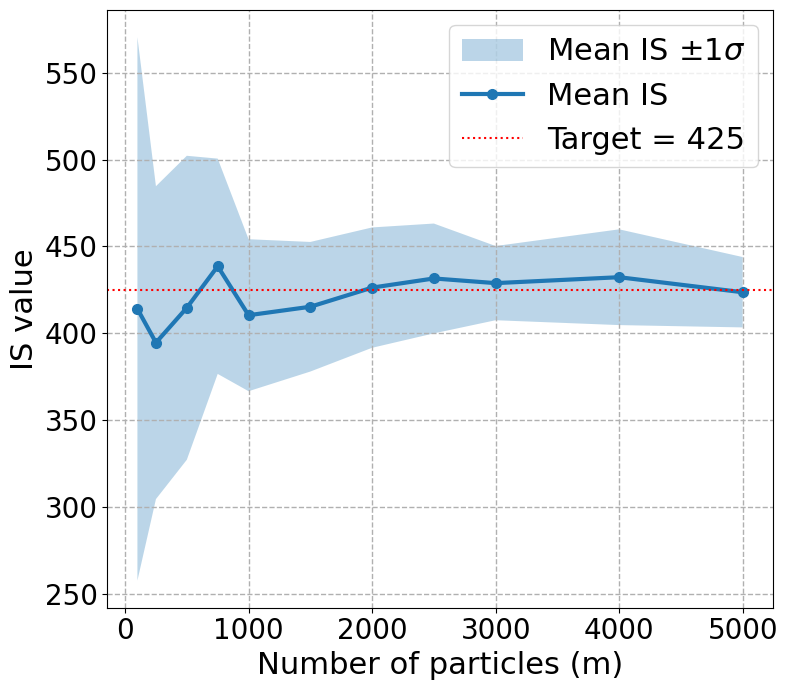

In [20]:
# Ensure lists are converted to NumPy arrays
m_values = np.array(m_values)
mean_IS = np.array(mean_IS)
std_IS = np.array(std_IS)

# Compute bounds
lower = mean_IS - std_IS
upper = mean_IS + std_IS

plt.figure(figsize=(8, 7))
plt.fill_between(m_values, lower, upper, alpha=0.3, label=r"Mean IS ±1$\sigma$")
plt.plot(m_values, mean_IS, "o-", label="Mean IS", linewidth=3,markersize=7)
plt.axhline(y=425,
            color="red",          # red line
            linestyle=":",        # dotted style
            linewidth=1.5,
            label=f"Target = {425}")
#plt.title(r"Implementation Shortfall vs. Particle Count ($\delta = 1$)", fontsize = 16)
plt.xlabel("Number of particles (m)", fontsize = n)
plt.ylabel("IS value", fontsize = n)
plt.legend(loc = "best", fontsize = n)
plt.tick_params(axis="both", which="major", labelsize=n-2)
plt.grid(True, which="both", linestyle="--", linewidth=1)
plt.tight_layout()
plt.savefig('partciles_delta1.pdf', bbox_inches = 'tight')

In [1]:
import os
import pickle
import matplotlib.pyplot as plt

# ------------------------------------------------------------------
# 1. Load the results ------------------------------------------------
# ------------------------------------------------------------------
results_dir  = "particle count"
pickle_file  = "//nfs/home/colinn/Report_AC/Report_AC_basic/delta sweep/delta_sweep.pkl"

with open(pickle_file, "rb") as f:
    delta_results = pickle.load(f)


In [2]:
for i in delta_results.keys():
    print(delta_results[i].keys())

dict_keys(['mean_inventory', 'std_inventory', 'inventory_runs', 'trade_runs', 'obj_vals', 'mean_obj', 'std_obj', 'solve_times', 'mean_time', 'std_time', 'tail_probs', 'mean_tail', 'std_tail'])
dict_keys(['mean_inventory', 'std_inventory', 'inventory_runs', 'trade_runs', 'obj_vals', 'mean_obj', 'std_obj', 'solve_times', 'mean_time', 'std_time', 'tail_probs', 'mean_tail', 'std_tail'])
dict_keys(['mean_inventory', 'std_inventory', 'inventory_runs', 'trade_runs', 'obj_vals', 'mean_obj', 'std_obj', 'solve_times', 'mean_time', 'std_time', 'tail_probs', 'mean_tail', 'std_tail'])
dict_keys(['mean_inventory', 'std_inventory', 'inventory_runs', 'trade_runs', 'obj_vals', 'mean_obj', 'std_obj', 'solve_times', 'mean_time', 'std_time', 'tail_probs', 'mean_tail', 'std_tail'])
dict_keys(['mean_inventory', 'std_inventory', 'inventory_runs', 'trade_runs', 'obj_vals', 'mean_obj', 'std_obj', 'solve_times', 'mean_time', 'std_time', 'tail_probs', 'mean_tail', 'std_tail'])


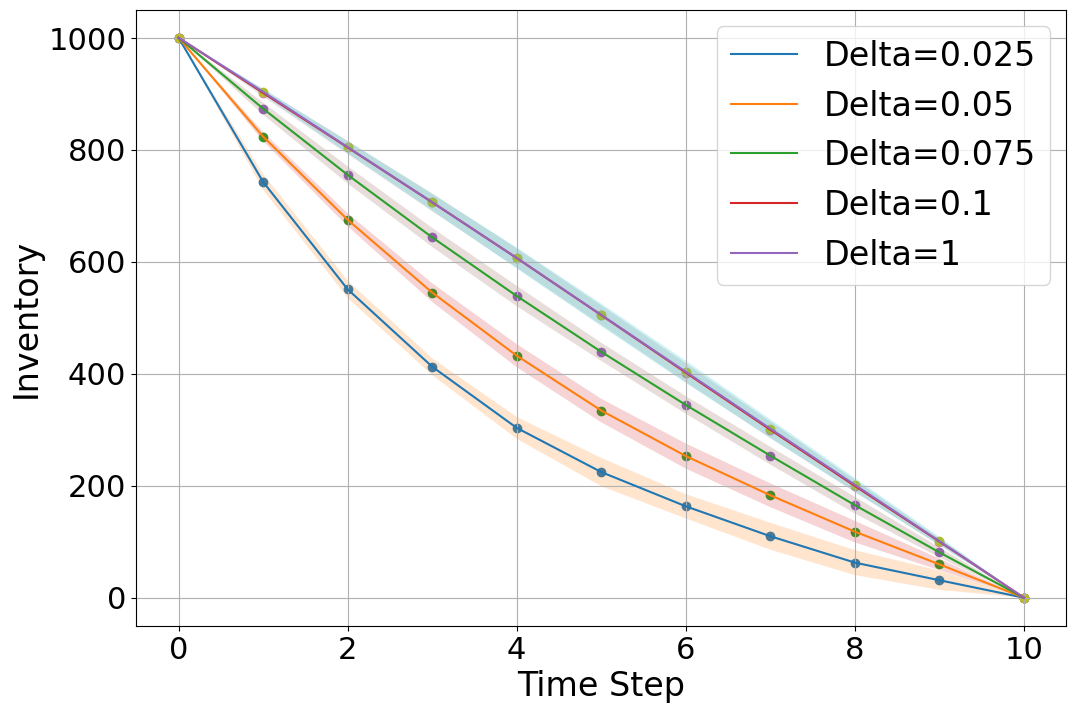

In [3]:
plt.figure(figsize=(12, 8))
time_steps = range(11)
n = 24
for i in delta_results.keys():
    mean_traj = delta_results[i]['mean_inventory']
    std_traj  = delta_results[i]['std_inventory']
    upper_bound = mean_traj + std_traj
    lower_bound = mean_traj - std_traj
    plt.scatter(time_steps, mean_traj)
    plt.plot(time_steps, mean_traj, label=f'Delta={i}')
    plt.fill_between(time_steps, lower_bound, upper_bound, alpha=0.2)
    #plt.title('Average Inventory Trajectories for Different Delta Values')
    plt.xlabel('Time Step', fontsize = n)
    plt.ylabel('Inventory', fontsize = n)
    plt.legend(loc = "best", fontsize = n)
    plt.tick_params(axis="both", which="major", labelsize=n-2)
    plt.grid(True)
    #plt.savefig('delta_inventory_scehdule.pdf', bbox_inches = 'tight')

In [4]:
import numpy as np

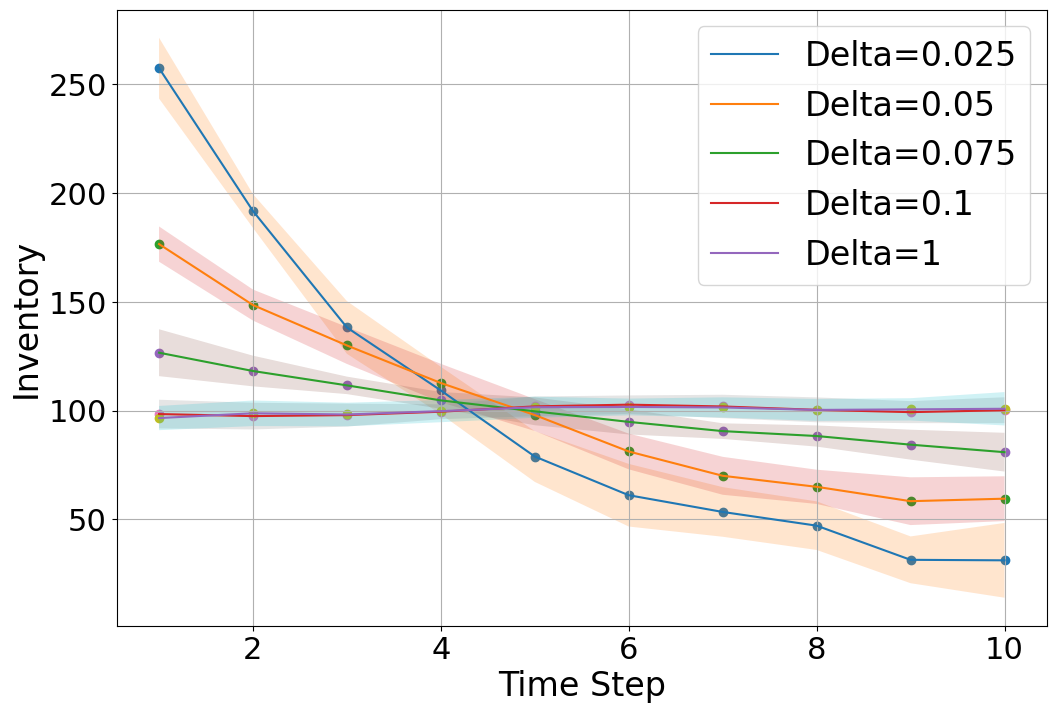

In [6]:
plt.figure(figsize=(12, 8))
time_steps = range(1,11)
n = 24
for i in delta_results.keys():
    trade_plots = delta_results[i]['trade_runs']
    mean_traj = np.array(trade_plots).mean(axis=0)
    std_traj  = np.array(trade_plots).std(axis=0)
    upper_bound = mean_traj + std_traj
    lower_bound = mean_traj - std_traj
    plt.scatter(time_steps, mean_traj)
    plt.plot(time_steps, mean_traj, label=f'Delta={i}')
    plt.fill_between(time_steps, lower_bound, upper_bound, alpha=0.2)
    #plt.title('Average Inventory Trajectories for Different Delta Values')
    # plt.axhline(y=100,
    #         color="red",          # red line
    #         linestyle=":",        # dotted style
    #         linewidth=1.5,
    #         label=f"No Risk Strategy")
    plt.xlabel('Time Step', fontsize = n )
    plt.ylabel('Inventory', fontsize = n)
    plt.legend(loc = "best", fontsize = n)
    plt.tick_params(axis="both", which="major", labelsize=n-2)
    plt.grid(True)
    #plt.savefig('delta_trading_scehdule.pdf', bbox_inches = 'tight')

In [11]:
plt.figure(figsize=(12, 8))
time_steps = range(11)

for i in delta_results.keys():
    mean_traj = delta_results[i]['mean_obj']
    std_traj  = delta_results[i]['std_obj']
    print('E[IS]' ,mean_traj, std_traj)
    mean_traj = delta_results[i]['mean_tail']
    std_traj  = delta_results[i]['std_tail']
    print('Tail Prob:', mean_traj, std_traj)

E[IS] 548.8113708200489 27.528519633490703
Tail Prob: 0.02500000000000001 6.938893903907228e-18
E[IS] 475.3535293167355 31.443312490460585
Tail Prob: 0.05000000000000002 1.3877787807814457e-17
E[IS] 432.29537514253246 29.145558332121006
Tail Prob: 0.07499999999999998 1.3877787807814457e-17
E[IS] 410.9197097108278 29.00158721999382
Tail Prob: 0.09456666666666669 0.003458644564308718
E[IS] 408.1188083410942 27.013207990753926
Tail Prob: 1.0 0.0


<Figure size 1200x800 with 0 Axes>

In [10]:
import numpy as np
import math

def compute_stochastic_variance(n, X, sigma, tau):
    # Compute the cumulative sum of the trade vector n.
    inventory = np.cumsum(n)  # This gives an array of [n0, n0+n1, n0+n1+n2, ..., total shares traded]
    remaining_inventory = X - inventory
    variance = sigma**2 * tau * np.sum(remaining_inventory**2)
    return variance
def compute_expected_IS(n, X, gamma, s, eta, tau, kappa, rho):
    # Permanent Impact:
    permanent = 0.5 * gamma * X**2 - 0.5 * gamma * np.sum(n**2)
    
    # Spread Cost:
    spread = s * X
    
    # Temporary Impact:
    temporary = eta * np.sum(n**2) / tau  # Since eta * sum(n[k]^2/tau)
    # Transient Impact:
    transient = 0.0
    # n is assumed to have length N+1; time steps k=0,...,N.
    N = len(n) - 1
    for k in range(N+1):
        inner_sum = 0.0
        # Sum over all previous time steps (i from 0 up to k-1)
        for i in range(0, k):
            inner_sum += n[i] * math.exp(-rho * tau * (k - i))
        transient += n[k] * inner_sum
    transient = kappa * transient
    
    # The stochastic term has expected value of zero.
    expected_IS = permanent + spread + temporary + transient
    return expected_IS

# --- Example usage ---
# Define parameters for a sample problem:
N = 10                # Number of intervals (so n has 11 entries)
X = 1e3               # Total shares
gamma = 2.5e-04
s = 0.0625
tau = 10 / N         # Trading horizon T=1 divided into N intervals
eta = 2.5e-03      # As defined in your code
kappa = 0
rho = 0
sigma = 0.95      # volatility, for instance

for i in delta_results.keys():
    trade_plots = delta_results[i]['trade_runs']
    mean_traj = np.array(trade_plots).mean(axis=0)
    print(i)
    print('E[trade]' ,mean_traj)
    n = mean_traj  # Example: all shares sold at time 0

    expected_IS = compute_expected_IS(n, X, gamma, s, eta, tau, kappa, rho)
    print("Expected IS:", expected_IS)
    variance = compute_stochastic_variance(n, X, sigma, tau)
    print("Variance of the stochastic term:", variance, np.sqrt(variance))

0.025
E[trade] [257.43509343 191.75764986 138.23114616 109.27139754  78.91908655
  61.13617022  53.44881462  47.14716171  31.44347771  31.21000219]
Expected IS: 546.3628619479543
Variance of the stochastic term: 1092890.5592692809 1045.4140611591565
0.05
E[trade] [176.56467391 148.53727029 129.96855605 112.70267696  97.98272421
  81.24007087  70.06537314  64.9980937   58.39414281  59.54641807]
Expected IS: 460.9153379826554
Variance of the stochastic term: 1664168.2743504494 1290.0264626551075
0.075
E[trade] [126.64394925 118.22361068 111.62755499 104.72098365  99.69764089
  94.84494028  90.60433958  88.34543183  84.37392083  80.91762792]
Expected IS: 429.88910957215535
Variance of the stochastic term: 2208292.892143988 1486.0326013059027
0.1
E[trade] [ 98.44443969  97.50097651  97.95286102  99.51625161 101.979125
 102.76463854 101.93818765 100.37791034  99.31968601 100.20592362]
Expected IS: 425.0690043363584
Variance of the stochastic term: 2600761.2516243877 1612.6875864916885
1
E[t